In [45]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

## Load the 3 data sets from Word Data Bank
***
### Country dataframe

In [46]:
country = pd.DataFrame.from_csv('data/Country.csv', index_col = None)
country.head(2)

,CountryCode,ShortName,TableName,LongName,Alpha2Code,CurrencyUnit,SpecialNotes,Region,IncomeGroup,Wb2Code,...,GovernmentAccountingConcept,ImfDataDisseminationStandard,LatestPopulationCensus,LatestHouseholdSurvey,SourceOfMostRecentIncomeAndExpenditureData,VitalRegistrationComplete,LatestAgriculturalCensus,LatestIndustrialData,LatestTradeData,LatestWaterWithdrawalData
0,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2013.0,2000.0
1,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,Budgetary central government,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2011.0,2013.0,2006.0


In [47]:
country.shape

(247, 31)

The Country data frame has 31 descriptor columns for each of the 247 rows (countries of groups of countries). Let's get a sense for how many individual countries exist and how many aggregate groupings (e.g. world, regions, income groupings). 

In [48]:
# ID aggregated rows by searching for 'aggregate' in the special notes column 
text = country.SpecialNotes.fillna('0')
len(text[text.str.contains('aggregate')])

33

### Load 'Series' dataframe (renamed as metrics)

In [49]:
metrics = pd.DataFrame.from_csv('data/Series.csv', index_col = None)

One row per series/metric, columns provide defintions, units, periodicity sources, etc. Now let's get a better sense for the key categories (and sub-categories) of development indicators.

Interested in health/life expactancy as the target indicators. SP.DYN.LE00.IN is a good fit: Life expectancy at birth, total (years)

In [50]:
metrics[metrics.IndicatorName.str.contains('Life expectancy')].head()

,SeriesCode,Topic,IndicatorName,ShortDefinition,LongDefinition,UnitOfMeasure,Periodicity,BasePeriod,OtherNotes,AggregationMethod,LimitationsAndExceptions,NotesFromOriginalSource,GeneralComments,Source,StatisticalConceptAndMethodology,DevelopmentRelevance,RelatedSourceLinks,OtherWebLinks,RelatedIndicators,LicenseType
818,SP.DYN.LE00.FE.IN,Health: Mortality,"Life expectancy at birth, female (years)",Life expectancy at birth indicates the average...,Life expectancy at birth indicates the number ...,NaN,Annual,NaN,NaN,Weighted average,Complete vital registration systems are not co...,NaN,NaN,(1) United Nations Population Division. World ...,Life expectancy at birth used here is the aver...,Mortality rates for different age groups (infa...,NaN,NaN,NaN,Open
819,SP.DYN.LE00.MA.IN,Health: Mortality,"Life expectancy at birth, male (years)",Life expectancy at birth indicates the average...,Life expectancy at birth indicates the number ...,NaN,Annual,NaN,NaN,Weighted average,Complete vital registration systems are not co...,NaN,NaN,(1) United Nations Population Division. World ...,Life expectancy at birth used here is the aver...,Mortality rates for different age groups (infa...,NaN,NaN,NaN,Open
820,SP.DYN.LE00.IN,Health: Mortality,"Life expectancy at birth, total (years)",Life expectancy at birth indicates the average...,Life expectancy at birth indicates the number ...,NaN,Annual,NaN,NaN,Weighted average,Complete vital registration systems are not co...,NaN,NaN,Derived from male and female life expectancy a...,Life expectancy at birth used here is the aver...,Mortality rates for different age groups (infa...,NaN,NaN,NaN,Open


Briefly view all the indicator categories that are available as predictors of Life Expectancy

In [51]:
# Highlevel topic categories
splitTopics = metrics.Topic.str.partition(':')
splitTopics.groupby([0,2]).size()

0                          2                                                                          
Economic Policy & Debt      Balance of payments: Capital & financial account                              11
                            Balance of payments: Current account: Balances                                 4
                            Balance of payments: Current account: Goods, services & income                22
                            Balance of payments: Current account: Transfers                                7
                            Balance of payments: Reserves & other items                                    6
                            External debt: Amortization                                                   18
                            External debt: Arrears, reschedulings, etc.                                   22
                            External debt: Commitments                                                     5
                         

### Load 'Indicators' dataframe (renamed as 'df')
***

In [52]:
df = pd.DataFrame.from_csv('data/indicators.csv', index_col=None)

#check availability of data and how missing values are handled (confirm unavailable data reported as'NaN')
df[df.IndicatorName.str.contains('GDP per capita')].groupby(['CountryName', 'IndicatorName']).size().unstack()

IndicatorName,GDP per capita (constant 2005 US$),GDP per capita (constant LCU),GDP per capita (current LCU),GDP per capita (current US$),GDP per capita growth (annual %),"GDP per capita, PPP (constant 2011 international $)","GDP per capita, PPP (current international $)",Government expenditure per primary student as % of GDP per capita (%),Government expenditure per secondary student as % of GDP per capita (%),Government expenditure per tertiary student as % of GDP per capita (%)
CountryName,,,,,,,,,,
Afghanistan,13.0,13.0,36.0,36.0,12.0,13.0,13.0,NaN,NaN,NaN
Albania,35.0,35.0,35.0,31.0,34.0,25.0,25.0,NaN,NaN,NaN
Algeria,55.0,55.0,55.0,55.0,54.0,25.0,25.0,4.0,4.0,NaN
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
Andorra,44.0,44.0,44.0,44.0,43.0,NaN,NaN,9.0,9.0,5.0
Angola,1.0,18.0,29.0,29.0,17.0,1.0,1.0,NaN,NaN,2.0
Antigua and Barbuda,38.0,38.0,38.0,38.0,37.0,25.0,25.0,1.0,2.0,1.0
Arab World,40.0,NaN,NaN,47.0,39.0,25.0,25.0,NaN,NaN,NaN
Argentina,55.0,55.0,55.0,53.0,54.0,NaN,NaN,15.0,15.0,15.0


## Data wrangling & inferential statistics
*** 

### Plot life expectancy trends for high, med, and low income countries

In [53]:
income = country[['CountryCode','IncomeGroup', 'SpecialNotes']]
df_Le = df.merge(income, left_on=df.CountryCode, right_on = income.CountryCode, how='outer')
df_Le = df_Le[(df_Le.IndicatorName =='Life expectancy at birth, total (years)') 
                              & (df_Le.SpecialNotes.str.contains('aggregate'))]

df_Le = pd.pivot_table(df_Le, values = 'Value', index='Year', columns='CountryName')

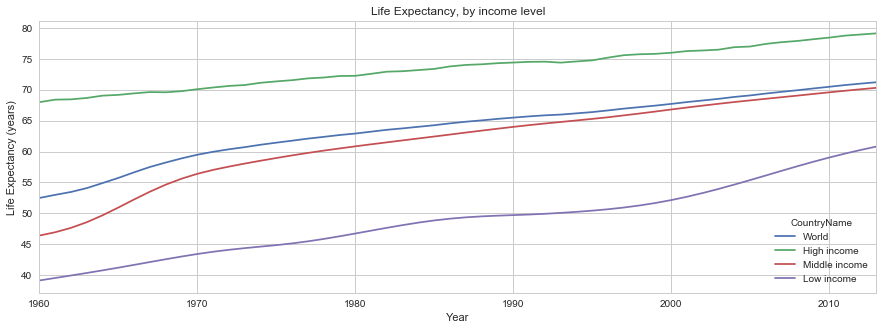

In [54]:
income_grps = ['World', 'High income', 'Middle income', 'Low income']

df_Le[income_grps].plot(figsize=(15,5))
plt.title('Life Expectancy, by income level')
plt.ylabel('Life Expectancy (years)')

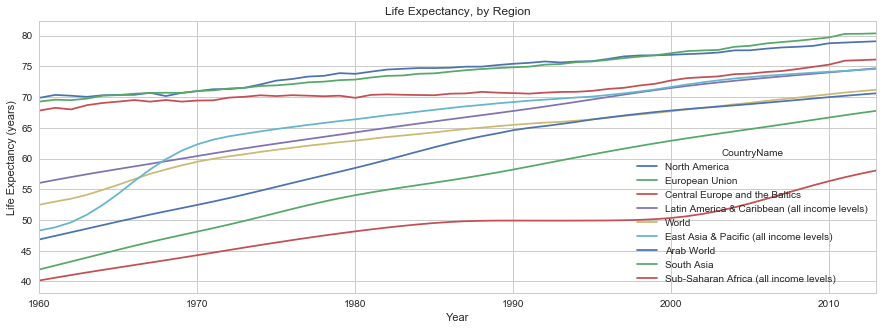

In [55]:
regions = ['North America','European Union','Central Europe and the Baltics', 
        'Latin America & Caribbean (all income levels)','World',
        'East Asia & Pacific (all income levels)','Arab World',  
        'South Asia', 'Sub-Saharan Africa (all income levels)']

df_Le[regions].plot(figsize=(15,5))
plt.title('Life Expectancy, by Region')
plt.ylabel('Life Expectancy (years)')
plt.show()

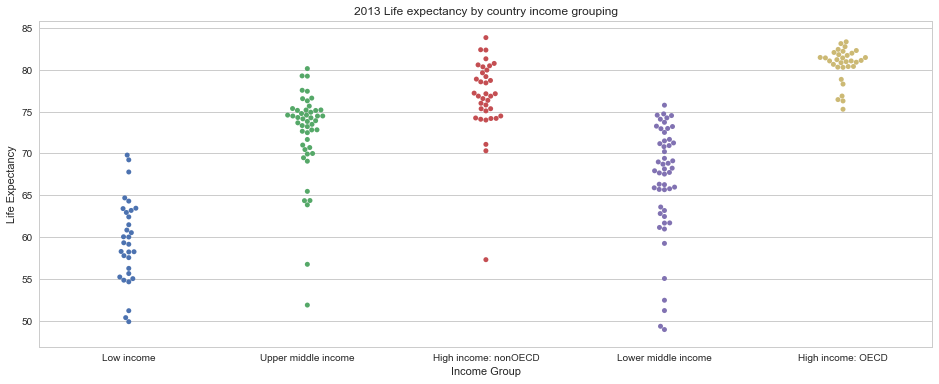

In [56]:
# Plot 2013 life expectancy for all countries, by income grouping
df_2013 = df.merge(income, left_on=df.CountryCode, right_on = income.CountryCode, how='outer')

df_2013 = df_2013[(df_2013.IndicatorName =='Life expectancy at birth, total (years)') & (df_2013.Year == 2013)]

sns.set_style("whitegrid")
# fig.set_style
plt.figure(figsize=(16, 6))
_ = sns.swarmplot(x='IncomeGroup', y = 'Value', data = df_2013)
_ = plt.xlabel('Income Group')
_ = plt.ylabel('Life Expectancy')
_ = plt.title('2013 Life expectancy by country income grouping')

plt.show()

In [57]:
df_2013.groupby(['IncomeGroup']).describe().unstack()

Value                                             \
                     count       mean       std        min        25%   
IncomeGroup                                                             
High income: OECD     32.0  80.635077  2.010744  75.268293  80.355488   
High income: nonOECD  36.0  76.792581  4.570202  57.290829  74.920841   
Low income            31.0  59.531009  5.020727  49.879878  55.942305   
Lower middle income   51.0  66.887601  6.665756  48.937927  63.375280   
Upper middle income   48.0  72.507274  5.290481  51.866171  70.915787   

                                                       Year               \
                            50%        75%        max count    mean  std   
IncomeGroup                                                                
High income: OECD     81.074390  81.840244  83.331951  32.0  2013.0  0.0   
High income: nonOECD  76.981500  79.705738  83.831707  36.0  2013.0  0.0   
Low income            59.312024  63.055024  69.791951  31.0  2013.0  0.0   
Lower middle income   68.131561  71.577817  75.756488  51.0  2013.0  0.0   
Upper middle income   74.011927  75.146427  80.128878  48.0  2013.0  0.0   

                                                              
                         min     25%     50%     75%     max  
IncomeGroup                                                   
High income: OECD     2013.0  2013.0  2013.0  2013.0  2013.0  
High income: nonOECD  2013.0  2013.0  2013.0  2013.0  2013.0  
Low income            2013.0  2013.0  2013.0  2013.0  2013.0  
Lower middle income   2013.0  2013.0  2013.0  2013.0  2013.0  
Upper middle income   2013.0  2013.0  2013.0  2013.0  2013.0

### Machine learning: Predicting life expectancy with linear regression

In [154]:
columns = {
            "SP.DYN.LE00.IN": "LifeExpect_total",
#             "SH.XPD.PCAP": "HealthExp_perCap",
#             "NY.ADJ.AEDU.GN.ZS": "EduExp_percentGNI",
#             'NY.ADJ.NNTY.KD.ZG': 'Adj_nat_income_%dlt',
            'SP.ADO.TFRT': 'Adol_fertility',
#             'AG.LND.AGRI.ZS': 'Agri_land_perc',
#             'AG.LND.ARBL.ZS': 'Arable_land_perc',
#             'MS.MIL.TOTL.TF.ZS': 'Armed_forces_perc',
#             'SL.EMP.1524.SP.ZS': 'Employ_ratio_15',
#             'SE.PRM.ENRR': 'Primary_edu',
#             'SE.PRM.ENRL': 'Secondary_edu',
            'NY.GDP.PCAP.CD': 'GDP_per_capita_US$',
#             'SH.XPD.TOTL.ZS': 'Health_exp_perc',
#             'NE.IMP.GNFS.ZS': 'Imports_perGDP',
            'SH.STA.ACSN': 'Sanitation_perc_access',
#             'NV.IND.TOTL.ZS': 'Industry_percGDP',
#             'IT.CEL.SETS.P2': 'Mobile_phone_per100',
#             'EN.POP.DNST': 'Pop_density',
#             'SM.POP.REFG': 'Refugee_population',
            'SP.RUR.TOTL.ZS': 'Rural_population_per',
#             'NE.TRD.GNFS.ZS': 'Trade_percGDP',
#             'SL.UEM.TOTL.ZS': 'Unemployment_perc'
#             'SH.MMR.RISK': 'Maternal_death_perc',
#             'SP.DYN.IMRT.IN': 'Mortality_infant _per1000',
#             'SH.DYN.NMRT': 'Mortality_neonatal_1000',
#             'SH.DYN.MORT': 'Mortality_sub5_1000'
          }

In [166]:
df.IndicatorCode = df.IndicatorCode.astype(str)
df.IndicatorName = df.IndicatorName.astype(str)

# piovt the 2013 data so the features are column headers
pivot = df[df.Year==2013].pivot_table('Value','CountryName', 'IndicatorCode')

features = list(columns.keys())
df_features = pivot[features]
df_features.columns = df_features.columns.to_series()
flattened = pd.DataFrame(df_features.to_records())

df_ml = flattened.rename(index=str, columns=columns)

# Drop countries who do not have a life expectancy value 
df_ml = df_ml[pd.notnull(df_ml.LifeExpect_total)]
df_ml = df_ml.dropna(axis =0, how='any').drop('CountryName', axis = 1)

df_ml.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [156]:
y = df_ml.LifeExpect_total.values.reshape(-1,1)
X = df_ml.drop(['LifeExpect_total'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42) 
lr = LinearRegression(normalize=True)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

0.72362364488412767

In [157]:
cv_results = cross_val_score(lr, X, y, cv = 10)
print(np.mean(cv_results))

0.784163103431


# Access to sanitation is the biggest drive for life expectancy
Let's dig into the age groups most affected by poor sanitation. We have Mortality rates for neonatals, infants and children under 5, as well as the maternal death rate. Repeating the steps above, we'll create a sub-set of the dataframe with the relevant columns, then run a correlation across this sub-set. 

In [159]:
# Create a sub-set of columns for 
colums_san = {
            'SH.STA.ACSN': 'Sanitation_perc_access',
            "SP.DYN.LE00.IN": "LifeExpect_total",
            'SH.MMR.RISK': 'Maternal_death_perc',
            'SP.DYN.IMRT.IN': 'Mortality_infant _per1000',
            'SH.DYN.NMRT': 'Mortality_neonatal_1000',
            'SH.DYN.MORT': 'Mortality_sub5_1000',
          }

In [160]:
df.IndicatorCode = df.IndicatorCode.astype(str)
df.IndicatorName = df.IndicatorName.astype(str)

# piovt the 2013 data so the features are column headers
pivot_san = df[df.Year==2013].pivot_table('Value','CountryName', 'IndicatorCode')

features = list(columns_san.keys())
df_features = pivot[features]
df_features.columns = df_features.columns.to_series()
flattened = pd.DataFrame(df_features.to_records())

df_ml = flattened.rename(index=str, columns=columns_san)

# Drop countries who do not have a life expectancy value 
df_ml = df_ml[pd.notnull(df_ml.LifeExpect_total)]
df_ml = df_ml.dropna(axis =0, how='any').drop('CountryName', axis = 1)

In [165]:
df_ml.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)